In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier as DFS

import warnings

from typing import List

warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 0. Некоторые полезные штуки

In [3]:
def isnan(value):
    return value is None or value != value

In [4]:
def analyze(series, categorical: bool = None):

  if isinstance(series, pd.DataFrame):
    series = series.iloc[:, 0]

  series_unique = sorted(series.unique())

  if categorical is None:
    categorical = len(series_unique) < 30


  max_len = 10

  print(
    f"unique: {len(series_unique)}",
    f"empty: {sum([isnan(el) for el in series])}",
    f"filled: {sum([not isnan(el) for el in series])},",
    f"values: {list(series_unique[:max_len]) + [] if len(series_unique) < max_len else ['...']}" if categorical else ""
  )
  if categorical:
    for val in series_unique[:max_len]:
      if isnan(val):
        print(f"{val} - {sum(series.isna())} times")
      else:
        print(f"{val} - {sum(series == val)} times")
    if len(series_unique) < 30:
      series.hist(xrot=-30)
  else:
    print(f"min: {series.min()}, mean: {series.mean()}, max: {series.max()}, std: {series.std()}")
    series.hist()
  plt.show()

# 1. Загружаем данные

In [5]:

filename = 'output.xlsx'


In [6]:
covid_contracts_positions_with_lot = pd.read_excel(filename)
print(list(covid_contracts_positions_with_lot.columns))
covid_contracts_positions_with_lot

['Unnamed: 0', 'contract_guid', 'contract_registration_number', 'notice_not_placed_by_fz223p5s4', 'contract_extension', 'contract_prolongation', 'customer_appeale_or_needs_approval', 'customer_approval_or_antimonopoly_descision_date', 'contract_plan_position_guid', 'contract_create_date_time', 'contract_customer_inn', 'contract_placer_inn', 'contract_detached_org_inn', 'contract_publication_date', 'contract_publication_date.1', 'emergency', 'provider', 'provider_code', 'contract_reg_number', 'contract_date', 'digital_purchase', 'purchase_notice_info_guid', 'purchase_notice_info_number', 'lot_guid', 'subject_contract', 'purchase_type_code', 'contract_price', 'contract_rub_price', 'contract_currency_code', 'contract_start_execution_date', 'contract_end_execution_date', 'region_name', 'notice_lot_initial_sum', 'notice_lot_starting_contract_price_rub', 'notice_lot_currency_code', 'notice_lot_commodity_price', 'notice_lot_commodity_price_rub', 'notice_lot_max_contract_price', 'notice_lot_ma

,Unnamed: 0,contract_guid,contract_registration_number,notice_not_placed_by_fz223p5s4,contract_extension,contract_prolongation,customer_appeale_or_needs_approval,customer_approval_or_antimonopoly_descision_date,contract_plan_position_guid,contract_create_date_time,contract_customer_inn,contract_placer_inn,contract_detached_org_inn,contract_publication_date,contract_publication_date.1,emergency,provider,provider_code,contract_reg_number,contract_date,digital_purchase,purchase_notice_info_guid,purchase_notice_info_number,lot_guid,subject_contract,purchase_type_code,contract_price,contract_rub_price,contract_currency_code,contract_start_execution_date,contract_end_execution_date,region_name,notice_lot_initial_sum,notice_lot_starting_contract_price_rub,notice_lot_currency_code,notice_lot_commodity_price,notice_lot_commodity_price_rub,notice_lot_max_contract_price,notice_lot_max_contract_price_rub,contract_is_complete,contract_position_name,position_okpd2_code,position_okpd2_name,position_country_code,position_producer_country,position_impossible_to_determine_attr,position_okei_code,position_okei_name,position_qty,position_unit_price,position_rub_unit_price,position_currency_code,contracts_for_lot,notice_customer_inn,notice_placer_inn,notice_detached_org_inn,contract_positions_count,supplier_inn,supplier_name,supplier_ogrn,supplier_type
0,0,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.00,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),4000.0,26.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
1,1,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.00,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),5000.0,26.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
2,2,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.00,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),1000.0,28.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
3,3,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b260-cb592f2fc8f9,Поставка перчаток медицинских для нужд ОГАУЗ «Поликлиника № 10»,40000,550800.00,550800.0,RUB,2021-01-11,2021-06-29,Tomskaya_obl,550800.0,NaN,RUB,NaN,NaN,NaN,NaN,1.0,Перчатки,22.19.60.111,Перчатки хирургические резиновые,NaN,NaN,0,715,Пара (2 шт.),100.0,54.0,NaN,RUB,1,7017000450,7017000450,NaN,8,NaN,NaN,NaN,NaN
4,4,00026a57-3035-45cd-9a0b-598d5b233a6b,57017000450210000030001,0,0,0,0,NaN,NaN,2021-01-12 02:56:07,7017000450,7017000450,NaN,2021-01-12 03:47:29,P,0.0,0,NaN,57017000450210000030000,2021-01-11,1,602e9024-21e9-4da1-88fe-e597cf556b70,32009825416,706d8038-0c86-437b-b26

# 2. Предобработка данных

### Выбор признаков

#### оставляем только необходимые в дальнейшем признаки

In [7]:
features = [
    'contract_guid',
    'contract_is_complete',
    'contract_extension',  # [0, 1] Договором предусмотрена возможность продления срока действия договора после его окончания
    'purchase_type_code',  # ['400002', '400001', '300002', '300001', '110112', '120121', '110111'] Код признака закупки в электронном виде
    'notice_lot_max_contract_price',
    'notice_lot_initial_sum',
    'region_name',  # ['Sankt-Peterburg', 'Moskva', 'Krasnodarskii_krai', 'Moskovskaya_obl', 'Leningradskaya_obl', 'Primorskii_krai']
    'notice_lot_currency_code',  # ['RUB', 'EUR', 'CZK', 'USD', 'GBP', 'JPY', 'MNT']
    'position_okpd2_code',
    'position_okpd2_name',
    'position_impossible_to_determine_attr',  # [0, 1] Невозможно определить количество (объем)
    'supplier_inn', # ИНН поставщика
    'supplier_type', # Физик / Юрик
    'notice_placer_inn', # ИНН заказчика
    'contract_rub_price', # сумма контрактов в валюте переведенная в рубли
    'contract_price', # сумма рублевых контрактов
    'contract_start_execution_date', # Дата начала контракта
    'contract_end_execution_date', # Дата завершения контракта
    'notice_lot_currency_code',
    'contracts_for_lot', # Договоров на лот
    'contract_positions_count' # Позиций в договоре

]

df = covid_contracts_positions_with_lot[features]
df = df.loc[:,~df.columns.duplicated()]
df.reset_index(drop=True, inplace=True)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,notice_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count
0,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.00,2021-01-11,2021-06-29,1,8
1,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.00,2021-01-11,2021-06-29,1,8
2,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.00,2021-01-11,2021-06-29,1,8
3,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.00,2021-01-11,2021-06-29,1,8
4,00026a57-3035-45cd-9a0b-598d5b233a6b,1.0,0,40000,NaN,550800.0,Tomskaya_obl,RUB,22.19.60.111,Перчатки хирургические резиновые,0,NaN,NaN,7017000450,550800.0,550800.00,2021-01-11,2021-06-29,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72190,fff5ad7e-5884-46f1-9f07-4150e8cc6258,NaN,0,30000,NaN,365400.0,Amurskaya_obl,RUB,32.50.50.000,"Изделия медицинские, в том числе хирургические, прочие",0,NaN,NaN,2801022793,NaN,365400.00,2021-10-31,2021-11-09,1,1
72191,fff6f724-be51-4180-930f-41999fdd5497,NaN,0,12012,NaN,686400.0,Saha_Jakutiya_Resp,RUB,21.20.10,Препараты лекарственные,1,NaN,NaN,7710357167,617760.0,617760.00,2021-11-24,2021-12-30,1,1
72192,fff8c702-ba6a-48c2-90d4-67c2c857cfd1,0.0,0,12012,NaN,23705828.4,Moskva,RUB,81.29.11.000,"Услуги по дезинфекции, дезинсекции и дератизации",0,NaN,NaN,7725038124,NaN,3200287.08,2020-11-16,NaN,1,1
72193,fffb9623-244a-4c27-b1c7-4518ab6412bd,1.0,0,40000,NaN,600600.0,Saha_Jakutiya_Resp,RUB,21.20.10,Препараты лекарственные,0,NaN,NaN,1431004812,NaN,600600.00,2021-07-06,2021-12-30,1,1


#### Убираем тех, у кого нет ИНН поставщика

In [8]:
df.dropna(subset=['supplier_inn'], inplace=True)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,notice_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count
53,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,26.51,"Оборудование для измерения, испытаний и навигации",0,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1
57,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,32.50.50.000,"Изделия медицинские, в том числе хирургические, прочие",0,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1
91,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,14.19.32.120,Одежда из нетканых материалов,0,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1
103,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,0,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1
1950,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,21.20.10.158,Антисептики и дезинфицирующие препараты,0,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71968,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,20.59.52.199,"Реагенты сложные диагностические или лабораторные прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2
71969,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,22.29.29.190,"Изделия пластмассовые прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2
72097,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,85.42.19.000,Услуги по дополнительному профессиональному образованию прочие,0,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1
72099,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,1,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1


#### Определяем стоимость договора в рублях и начальную цену договора

In [9]:
df['real_rub_price'] = df.apply(
    lambda row: row['contract_rub_price'] if not isnan(row['contract_rub_price']) else row['contract_price'],
    axis=1
)

df['real_initial_sum'] = df.apply(
    lambda row: row['notice_lot_max_contract_price'] if not isnan(row['notice_lot_max_contract_price']) else row['notice_lot_initial_sum'],
    axis=1
)

#### Убираем строки где нет начальной цены

In [10]:
df.dropna(subset=['real_initial_sum'], inplace=True)
df.drop(df[df['real_initial_sum'] == 0].index, inplace=True)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,notice_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,real_rub_price,real_initial_sum
53,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,26.51,"Оборудование для измерения, испытаний и навигации",0,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,243570.00,243570.00
57,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,32.50.50.000,"Изделия медицинские, в том числе хирургические, прочие",0,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,358403.76,358403.76
91,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,14.19.32.120,Одежда из нетканых материалов,0,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,520000.00,520000.00
103,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,0,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,157470.00,157470.00
1950,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,21.20.10.158,Антисептики и дезинфицирующие препараты,0,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,499850.00,499850.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71968,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,20.59.52.199,"Реагенты сложные диагностические или лабораторные прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,193847.52,193847.52
71969,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,22.29.29.190,"Изделия пластмассовые прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,193847.52,193847.52
72097,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,85.42.19.000,Услуги по дополнительному профессиональному образованию прочие,0,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,2208918.60,2208918.60
72099,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,20.20.14.000,Средства дезинфекционные,1,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,374300.00,300000.00


#### Приводим описание okpd2 к нижнему регистру

In [11]:
df['position_okpd2_name'] = df.apply(
    lambda row: str(row['position_okpd2_name']).lower(), axis=1
)

#### Определяем вид *ПОЗИЦИИ* по окпд2


In [12]:
def category(row):
  if row['position_okpd2_code'][:2] in ['37', '38', '61', '62', '80', '81', '82', '84', '95','96']:
      if 'услуги' in row['position_okpd2_name']:# это условие собирает ок
          return 'ХозУслуги'
      else:
          return 'МедУслуги'# ok
  elif row['position_okpd2_code'][:2] in ['05', '08', '16', '24', '25', '36', '41', '42', '43', '47', '71']:
      if ('перевооруж' in row['position_okpd2_name']
          or 'ремонт' in row['position_okpd2_name']
          or 'замена' in row['position_okpd2_name']
          or 'работы' in row['position_okpd2_name']) and ('элект' in row['position_okpd2_name'] or 'отопл' in row['position_okpd2_name']
                                                          or  'водопров' in row['position_okpd2_name'] or  'газов' in row['position_okpd2_name']
                                                           or 'рельс' in row['position_okpd2_name']):
          return 'ХозУслуги'#ok
      elif ('перевооруж' in row['position_okpd2_name']
          or 'ремонт' in row['position_okpd2_name']
          or 'замена' in row['position_okpd2_name']
          or 'работы' in row['position_okpd2_name']) and not ('элект' in row['position_okpd2_name'] or 'отопл' in row['position_okpd2_name']
                                                          or  'водопров' in row['position_okpd2_name'] or  'газов' in row['position_okpd2_name']
                                                           or 'рельс' in row['position_okpd2_name']):
          return 'Строительство'#ok
      elif ('емкости из' in row['position_okpd2_name'] or 'ферросплавы' in row['position_okpd2_name'] or 'винты' in row['position_okpd2_name']
             or 'котлы' in row['position_okpd2_name']  or 'проволок' in row['position_okpd2_name']  or 'труб' in row['position_okpd2_name']
            or 'электрод' in row['position_okpd2_name'] or 'труб' in row['position_okpd2_name']
            ):
        return 'ХозМат'#ok

      else:
          return 'ХозУслуги'#ok
  elif row['position_okpd2_code'][:2] in ['13', '14', '15', '20', '21', '22' , '23']:
      if ('медицин' in row['position_okpd2_name'] or 'маск' in row['position_okpd2_name'] or 'комбинез' in row['position_okpd2_name']
    or 'анальг' in row['position_okpd2_name'] or 'анест' in row['position_okpd2_name'] or 'антибиот' in row['position_okpd2_name'] or 'антисепт' in row['position_okpd2_name']
    or 'вазодил' in row['position_okpd2_name'] or 'стероид' in row['position_okpd2_name'] or 'гормон' in row['position_okpd2_name'] or 'добавки' in row['position_okpd2_name']
    or 'имуно' in row['position_okpd2_name'] or 'кислород' in row['position_okpd2_name'] or 'микроорганизм' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name']
    or 'санитарно' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name'] or 'санитарно' in row['position_okpd2_name']
    or 'пеницил' in row['position_okpd2_name'] or 'хирург' in row['position_okpd2_name'] or 'антианемич' in row['position_okpd2_name'] or 'антибактериал' in row['position_okpd2_name']
    or 'гематолог' in row['position_okpd2_name'] or 'препарат' in row['position_okpd2_name'] or 'налептик' in row['position_okpd2_name'] or 'плазмо' in row['position_okpd2_name']
    or 'нуклеин' in row['position_okpd2_name'] or 'диагност' in row['position_okpd2_name'] or 'спирт' in row['position_okpd2_name'] or 'дезинфекц' in row['position_okpd2_name']
    or 'средства защиты' in row['position_okpd2_name'] or 'фармацевт' in row['position_okpd2_name'] or 'сыворотк' in row['position_okpd2_name'] or 'цефалоспор' in row['position_okpd2_name']
    or 'эфир' in row['position_okpd2_name'] or 'антикоаг' in row['position_okpd2_name'] or 'контраст' in row['position_okpd2_name'] or 'химич' in row['position_okpd2_name']
    or 'иммун' in row['position_okpd2_name'] or 'индикатор' in row['position_okpd2_name']):
          return 'МедМат'#ok
      else:
          return 'ХозМат'#ok
  elif row['position_okpd2_code'][:2] in ['26', '27', '28', '32']:
      if ('протез' in row['position_okpd2_name'] or 'респиратор' in row['position_okpd2_name'] or 'средства защит' in row['position_okpd2_name']
          or 'средства индив' in row['position_okpd2_name'] or 'термометр' in row['position_okpd2_name'] or 'шприц' in row['position_okpd2_name']):
        return 'МедМат'#ok
      elif ('специального назн' in row['position_okpd2_name'] or 'рентген' in row['position_okpd2_name'] or 'медиц' in row['position_okpd2_name']
            or 'терапевт' in row['position_okpd2_name'] or 'дыхател' in row['position_okpd2_name'] or 'фильтров' in row['position_okpd2_name']
             or 'центрифуг' in row['position_okpd2_name'] or 'кардио' in row['position_okpd2_name'] or 'диагност' in row['position_okpd2_name']
            or 'ультрафиолет' in row['position_okpd2_name'] or 'терапии' in row['position_okpd2_name']):
          return 'МедОбор'#ok
      elif ('аппарат' in row['position_okpd2_name'] or 'компьютер' in row['position_okpd2_name'] or 'оборуд' in row['position_okpd2_name']
            or 'насос' in row['position_okpd2_name'] or 'трансформатор' in row['position_okpd2_name'] or 'устройств' in row['position_okpd2_name']
            or 'экспоном' in row['position_okpd2_name'] or 'редуктор' in row['position_okpd2_name'] or 'средств' in row['position_okpd2_name']
            or 'установк' in row['position_okpd2_name'] or 'машин' in row['position_okpd2_name']):
        return 'ХозОбор'#ok
      else:
          return 'ХозМат'#ok
  elif row['position_okpd2_code'][:2] in ['01' , '10' , '11', '46', '56']:
    if ('машин' in row['position_okpd2_name']):
      return 'ХозОбор'#ok
    elif ('водопровод' in row['position_okpd2_name']):
      return 'ХозМат'#ok
    elif ('фармац' in row['position_okpd2_name']):
      return 'МедМат'#ok
    else:
      return 'Еда'   #ok
  elif row['position_okpd2_code'][:2] in  ['33', '52', '65', '72', '86']:
    if ('больн' in row['position_okpd2_name'] or 'медиц' in row['position_okpd2_name'] or 'врач' in row['position_okpd2_name'] ):
          return 'МедУслуги'#ok
    else:
      return 'ХозУслуги'#ok
  elif row['position_okpd2_code'][:2] in ['19', '29', '30', '45', '49', '51']:

    return 'Другое'

  return 'Другое'


df['position_category'] = df.apply(lambda row: category(row), axis=1)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,position_okpd2_code,position_okpd2_name,position_impossible_to_determine_attr,supplier_inn,supplier_type,notice_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,real_rub_price,real_initial_sum,position_category
53,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,26.51,"оборудование для измерения, испытаний и навигации",0,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,243570.00,243570.00,ХозОбор
57,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,32.50.50.000,"изделия медицинские, в том числе хирургические, прочие",0,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,358403.76,358403.76,МедОбор
91,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,14.19.32.120,одежда из нетканых материалов,0,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,520000.00,520000.00,ХозМат
103,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,20.20.14.000,средства дезинфекционные,0,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,157470.00,157470.00,МедМат
1950,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,21.20.10.158,антисептики и дезинфицирующие препараты,0,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,499850.00,499850.00,МедМат
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71968,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,20.59.52.199,"реагенты сложные диагностические или лабораторные прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,193847.52,193847.52,МедМат
71969,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,22.29.29.190,"изделия пластмассовые прочие, не включенные в другие группировки",0,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,193847.52,193847.52,ХозМат
72097,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,85.42.19.000,услуги по дополнительному профессиональному образованию прочие,0,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,2208918.60,2208918.60,Другое
72099,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,20.20.14.000,средства дезинфекционные,1,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,374300.00,300000.00,МедМат


#### Определяем вид *ДОГОВОРА* по позициям

##### Объединяем все встречающиеся типы позиций договора в список

In [13]:
contract_columns = df.columns.to_list()

contract_columns.remove('position_okpd2_code')
contract_columns.remove('position_okpd2_name')
contract_columns.remove('position_category')
contract_columns.remove('position_impossible_to_determine_attr')
contract_columns

['contract_guid',
 'contract_is_complete',
 'contract_extension',
 'purchase_type_code',
 'notice_lot_max_contract_price',
 'notice_lot_initial_sum',
 'region_name',
 'notice_lot_currency_code',
 'supplier_inn',
 'supplier_type',
 'notice_placer_inn',
 'contract_rub_price',
 'contract_price',
 'contract_start_execution_date',
 'contract_end_execution_date',
 'contracts_for_lot',
 'contract_positions_count',
 'real_rub_price',
 'real_initial_sum']

In [14]:
df = df.groupby(contract_columns, dropna=False)['position_category'].apply(list).reset_index()
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,notice_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,real_rub_price,real_initial_sum,position_category
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,243570.00,243570.00,[ХозОбор]
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,358403.76,358403.76,[МедОбор]
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,520000.00,520000.00,[ХозМат]
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,157470.00,157470.00,[МедМат]
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,499850.00,499850.00,[МедМат]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]"
2567,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,193847.52,193847.52,"[МедМат, ХозМат]"
2568,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,2208918.60,2208918.60,[Другое]
2569,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,374300.00,300000.00,[МедМат]


##### Выбираем в кочестве типа договора самый частый тип позиции
при этом, если самая частая позиция - Другое и есть что-то ещё, отбрасываем категорию другое

In [15]:
def get_most_frequent_category(category_okpd: List[str]) -> str:
    category_dict = {}
    for _category in category_okpd:
        category_dict[_category] = category_dict.get(_category, 0) + 1

    most_frequent_category = ''
    _max_count = 0
    _items_count = len(category_dict)
    for _category, _count in category_dict.items():
        if _items_count != 1 and _category == 'Другое':
            continue
        if _count > _max_count:
            most_frequent_category = _category
            _max_count = _count
    return most_frequent_category

In [16]:
df['contract_category'] = df['position_category'].map(get_most_frequent_category)
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,notice_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,real_rub_price,real_initial_sum,position_category,contract_category
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3.460072e+09,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,243570.00,243570.00,[ХозОбор],ХозОбор
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7.704544e+09,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,358403.76,358403.76,[МедОбор],МедОбор
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,6.106016e+11,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,520000.00,520000.00,[ХозМат],ХозМат
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6.671096e+09,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,157470.00,157470.00,[МедМат],МедМат
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7.726460e+09,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,499850.00,499850.00,[МедМат],МедМат
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5.321065e+09,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,974997.49,974997.49,"[ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги, ХозУслуги]",ХозУслуги
2567,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6.660140e+09,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,193847.52,193847.52,"[МедМат, ХозМат]",МедМат
2568,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7.207007e+09,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,2208918.60,2208918.60,[Другое],Другое
2569,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,4.630014e+11,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,374300.00,300000.00,[МедМат],МедМат


unique: 9 empty: 0 filled: 2571, values: ['Другое', 'Еда', 'МедМат', 'МедОбор', 'МедУслуги', 'Строительство', 'ХозМат', 'ХозОбор', 'ХозУслуги']
Другое - 119 times
Еда - 42 times
МедМат - 1027 times
МедОбор - 261 times
МедУслуги - 216 times
Строительство - 128 times
ХозМат - 343 times
ХозОбор - 50 times
ХозУслуги - 385 times


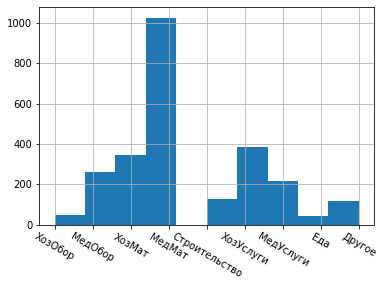

In [17]:
analyze(df['contract_category'], categorical=True)

In [18]:
df[df['contracts_for_lot'] > 1]

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,notice_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,real_rub_price,real_initial_sum,position_category,contract_category
80,07b2541b-36b3-404f-949a-48a8def2dae3,1.0,0,40000,NaN,1038434.20,Moskva,RUB,2.310219e+09,Юридическое лицо,7713059497,NaN,98700.00,2021-07-12,2021-12-30,4,3,98700.00,1038434.20,"[ХозМат, ХозМат, ХозМат]",ХозМат
212,14664be9-631c-4186-9ad7-7b5e14491e2f,1.0,0,40000,NaN,48600000.00,Volgogradskaya_obl,RUB,5.017112e+09,Юридическое лицо,3443012297,NaN,48600000.00,2020-11-10,2020-12-30,2,1,48600000.00,48600000.00,[МедМат],МедМат
291,1ce1dd6d-7c16-4a2b-93c8-0f073e3d51df,NaN,0,40000,NaN,78000000.00,Brianskaya_obl,RUB,5.050138e+09,Юридическое лицо,3201000327,NaN,500000.00,2020-07-27,2021-01-30,11,1,500000.00,78000000.00,[МедОбор],МедОбор
337,21c5c05d-e69e-4c53-9b35-924840cc8850,NaN,0,30000,NaN,228551.10,Ulianovskaya_obl,RUB,7.326024e+09,Юридическое лицо,7328041152,NaN,228551.10,2020-03-31,2020-12-30,2,11,228551.10,228551.10,"[Еда, ХозМат, Еда, Еда, Еда, Еда, Еда, Еда, Еда, Еда, Еда]",Еда
445,2cf271ca-50e9-41e9-9c0e-7f587fc564c9,NaN,0,40000,NaN,78000000.00,Brianskaya_obl,RUB,5.050138e+09,Юридическое лицо,3201000327,NaN,500000.00,2020-07-27,2021-01-30,11,1,500000.00,78000000.00,[МедОбор],МедОбор
610,3b2f18f0-23d5-497c-96a5-4170a35a34ac,NaN,0,40000,NaN,625170.00,Nizhegorodskaya_obl,RUB,6.234166e+09,Юридическое лицо,5260200603,NaN,625170.00,2020-04-14,2020-11-30,2,1,625170.00,625170.00,[ХозУслуги],ХозУслуги
647,3fb78c77-8c79-4de7-9fba-4e4ac1192ac9,NaN,0,40000,NaN,78000000.00,Brianskaya_obl,RUB,5.050138e+09,Юридическое лицо,3201000327,NaN,7000000.00,2020-07-27,2021-01-30,11,1,7000000.00,78000000.00,[МедОбор],МедОбор
650,40495987-5bdc-4c06-a5de-8168d730208c,NaN,0,30000,NaN,4345000.00,Karachaevo-Cherkesskaya_Resp,RUB,7.713054e+09,Юридическое лицо,901021165,NaN,4345000.00,2020-06-16,2020-12-30,2,2,4345000.00,4345000.00,"[МедМат, МедМат]",МедМат
655,40b676a6-e1d2-464d-a678-97008675b97f,1.0,0,40000,NaN,3845620.00,Moskva,RUB,7.701683e+09,Юридическое лицо,7713059497,77120.0,77120.00,2021-08-15,2021-12-30,2,1,77120.00,3845620.00,[МедМат],МедМат
667,41a2e253-c1db-4318-a2d8-b0bc79e5644a,NaN,0,30000,NaN,687000.00,Nizhegorodskaya_obl,RUB,6.234166e+09,Юридическое лицо,5260200603,NaN,687000.00,2020-04-19,NaN,2,1,687000.00,687000.00,[ХозУслуги],ХозУслуги
